In [8]:

import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
sys.path.append("/n/home12/binxuwang/Github/DiT")
import os
import time
import json
from os.path import join
import pickle as pkl
import torch
import torch as th
from tqdm import tqdm
import numpy as np
import einops
import seaborn as sns
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.edgecolor'] = (1, 1, 1, 0)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 0)
# vector graphics type
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

from train_edm import create_model, edm_sampler, EDM
from edm_utils import edm_sampler_inpaint, create_edm, get_default_config, create_edm_new
# from rule_utils import get_rule_img, get_obj_list, get_rule_list
# from rule_utils import check_consistent
from rule_new_utils import check_r3_r2_batch
from dataset_utils import train_data2attr_tsr,load_raw_data,load_PGM_abstract
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader, TensorDataset
from stats_plot_utils import saveallforms

import circuit_toolkit
print(circuit_toolkit.__file__)
from circuit_toolkit.layer_hook_utils import print_specific_layer, get_module_name_shapes, featureFetcher_module

def infer_rule_from_sample_batch(sample_batch):
    # if not int convert to int
    sample_batch = sample_batch.round().int()
    sample_batch = sample_batch.view(-1, 3, 3, 3, 9) 
    sample_batch = einops.rearrange(sample_batch, 
        "B attr row h (panel w) -> B row panel (h w) attr", 
        panel=3, w=3, h=3, attr=3)
    r3_list, r2_list, rule_col = check_r3_r2_batch(sample_batch)
    return r3_list, r2_list, rule_col


/n/home12/binxuwang/Github/circuit_toolkit/circuit_toolkit/__init__.py


### Data for obtaining repr

In [2]:
DATASET = "RAVEN10_abstract"
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)

if DATASET == "RAVEN10_abstract":
    in_channels = 3
    dataset_Xmean = th.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to("cuda")
    dataset_Xstd = th.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to("cuda")
    train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
    train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
elif DATASET == "RAVEN10_abstract_onehot":
    in_channels = 27
    dataset_Xmean = th.tensor([0.5, ]).view(1, 1, 1, 1)
    dataset_Xstd = th.tensor([0.5, ]).view(1, 1, 1, 1)
    raise NotImplementedError("RAVEN10_abstract_onehot not implemented.")
    # use the one-hot encoding
labels_tsr = th.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([120000, 3, 9, 9]) torch.Size([120000])


In [ ]:
config_mapping = {
    "WideBlnrX3_new_RAVEN10_abstract_20240315-1327": 
        # --layers_per_block 2 --model_channels 128 --channel_mult 1 2 4 --attn_resolutions 9 3 --train_batch_size 256 --spatial_matching bilinear
        dict(layers_per_block=2, model_channels=128, channel_mult=[1, 2, 4], attn_resolutions=[9, 3], spatial_matching="bilinear"),
    "WideBlnrX3_new_RAVEN10_abstract_20240412-1347":
        dict(layers_per_block=2, model_channels=128, channel_mult=[1, 2, 4], attn_resolutions=[9, 3], spatial_matching="bilinear"),
    "BigBlnrX3_new_RAVEN10_abstract_20240412-0143":
        # --layers_per_block 3 --model_channels 192 --channel_mult 1 2 4 --attn_resolutions 9 3 --train_batch_size 256 --spatial_matching bilinear
        dict(layers_per_block=3, model_channels=192, channel_mult=[1, 2, 4], attn_resolutions=[9, 3], spatial_matching="bilinear"),
    "WideBlnrX3_new_noattn_RAVEN10_abstract_20240412-1254":
        # --layers_per_block 2 --model_channels 128 --channel_mult 1 2 4 --attn_resolutions 0   --train_batch_size 256 --spatial_matching bilinear
        dict(layers_per_block=2, model_channels=128, channel_mult=[1, 2, 4], attn_resolutions=[0], spatial_matching="bilinear"),
    "BaseBlnrX3_new_RAVEN10_abstract_20240313-1736": 
        # --layers_per_block 1 --model_channels 64  --channel_mult 1 2 4 --attn_resolutions 9 3 --train_batch_size 256 --spatial_matching bilinear
        dict(layers_per_block=1, model_channels=64, channel_mult=[1, 2, 4], attn_resolutions=[9, 3], spatial_matching="bilinear"),
}

In [3]:
t_scalars = [0.1]
expname = "WideBlnrX3_new_RAVEN10_abstract_20240412-1347"
epoch = 100000

In [4]:

# expname = "WideBlnrX3_new_RAVEN10_abstract_20240315-1327"
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_expdir = join(expdir, "repr_classifier")
os.makedirs(repr_expdir, exist_ok=True)
device = "cuda"
# config_ft = get_default_config(DATASET, layers_per_block=2, 
#                                model_channels=128, 
#                                channel_mult=[1, 2, 4], 
#                                attn_resolutions=[9, 3], 
#                                spatial_matching="bilinear")
config_ft = get_default_config(DATASET, **config_mapping[expname])
# PC_dim = 1024
# # noPCA = False
# noPCA = True
use_ema = True
if epoch == -1:
    # use random initialization if epoch is -1
    edm, model_EDM = create_edm_new(None, config_ft, device) 
    ckpt_str = "ckptRNDINIT"
    print("Random initialization")
else:
    ckpt_path = join(ckptdir, f"ema_{epoch}.pth")
    edm, model_EDM = create_edm_new(ckpt_path, config_ft, device) 
    ckpt_str = f"ckpt{epoch:07d}EMA"
    print(f"Loaded {ckpt_str}: from {ckpt_path}, use_ema: {use_ema}")

model_EDM.to("cuda").eval();


Loaded ckpt0100000EMA: from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/WideBlnrX3_new_RAVEN10_abstract_20240412-1347/checkpoints/ema_100000.pth, use_ema: True


In [5]:
fetcher = featureFetcher_module()
record_module_list = ["input",
               'enc.9x9_conv',
                'enc.3x3_down',
                'enc.1x1_down',
                'dec.1x1_in0',
                'dec.1x1_in1',
                'dec.3x3_up',
                'dec.9x9_up',
                # 'dec.9x9_block2',
                "dec.9x9_aux_norm",
                "dec.9x9_aux_conv", ]
for blockname in list(model_EDM.enc):
    if f"enc.{blockname}" in record_module_list:
        fetcher.record_module(model_EDM.enc[blockname], target_name=f"enc.{blockname}")
for blockname in list(model_EDM.dec):
    if f"dec.{blockname}" in record_module_list:
        fetcher.record_module(model_EDM.dec[blockname], target_name=f"dec.{blockname}")

for t_scalar in t_scalars: # 0.3, 0.5, 0.7, 0.9, 1.0, 0.05, 0.02, 0.1
    t_str = str(t_scalar).replace('.', '_')
    t_beg = time.time()
    # t_scalar = 0.1
    train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, drop_last=False)
    feature_col = defaultdict(list)
    for X_batch, y_batch in tqdm(train_loader):
        t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
        X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
        with th.no_grad():
            model_EDM(X_batch_norm, t_vec, None)
        feature_col["input"].append(X_batch.float())
        for key, activations in fetcher.activations.items():
            feature_col[key].append(activations)
    for key in feature_col.keys():
        feature_col[key] = th.cat(feature_col[key], dim=0)
        print(key, feature_col[key].shape)

    feature_col_test = defaultdict(list)
    for X_batch, y_batch in tqdm(test_loader):
        t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
        X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
        with th.no_grad():
            model_EDM.forward(X_batch_norm, t_vec, None)
        feature_col_test["input"].append(X_batch.float())
        for key, activations in fetcher.activations.items():
            feature_col_test[key].append(activations)
            
    for key in feature_col_test.keys():
        feature_col_test[key] = th.cat(feature_col_test[key], dim=0)
        print(key, feature_col_test[key].shape)
    th.cuda.empty_cache() 
    t_feat = time.time()
    print(f"Feature extraction time: {t_feat - t_beg:.2f}")


  0%|          | 0/59 [00:00<?, ?it/s]

100%|██████████| 59/59 [00:41<00:00,  1.43it/s]


input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])
Feature extraction time: 63.26


In [6]:
feature_col_test["enc.1x1_down"].shape

torch.Size([40000, 256, 1, 1])

### Coarse graining cosine similarity matrix and UMap

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
layername = "enc.3x3_down"#"dec.1x1_in1"#"dec.3x3_up";#"dec.1x1_in1" # "enc.1x1_down"
# Compute the cosine similarity matrix
featmatr = feature_col_test[layername].flatten(start_dim=1)#.squeeze()
featmat_sparse = featmatr[::10,:]
cosine_sim_matrix = cosine_similarity(featmat_sparse)
# print(cosine_sim_matrix)
n = cosine_sim_matrix.shape[0]
reshaped = cosine_sim_matrix.reshape(n//100, 100, n//100, 100)
coarse_grained_matrix = reshaped.mean(axis=(1, 3))
# cosine_sim_matrix_nodiag = cosine_sim_matrix - np.eye(cosine_sim_matrix.shape[0]) 

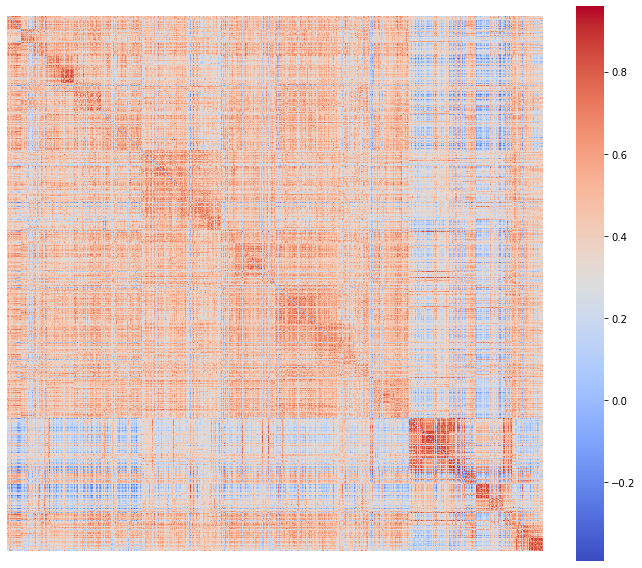

In [71]:
plt.figure(figsize=(12,10))
cosine_sim_matrix_nodiag = cosine_sim_matrix - np.eye(cosine_sim_matrix.shape[0]) 
sns.heatmap(cosine_sim_matrix_nodiag, annot=False, cmap='coolwarm', 
            xticklabels=False, yticklabels=False)
plt.axis("image")
plt.show()


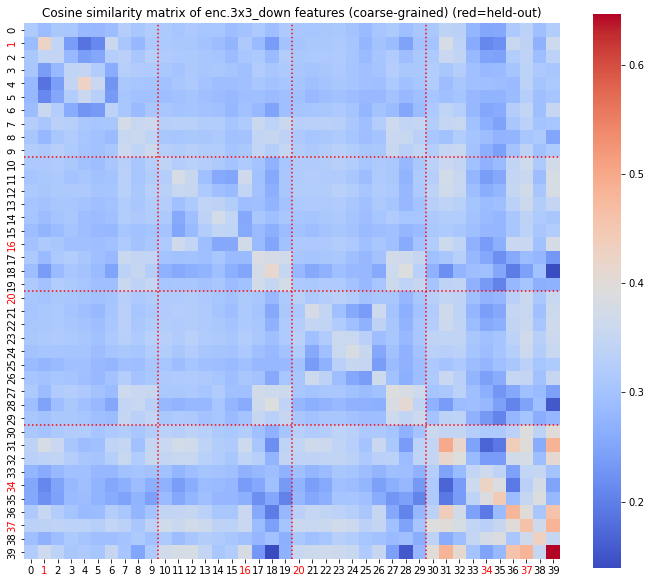

In [96]:
plt.figure(figsize=(12,10))
sns.heatmap(coarse_grained_matrix, annot=False, cmap='coolwarm', 
            xticklabels=True, yticklabels=True)
for sep in [10,20,30]:
    plt.axhline(sep, color="r", linestyle=":")
    plt.axvline(sep, color="r", linestyle=":")
xticks = plt.gca().get_xticklabels()
yticks = plt.gca().get_yticklabels()
for i, xtick in enumerate(xticks):
    if i in [1, 16, 20, 34, 37]:  # Change color of every 10th xtick label
        xtick.set_color('red')
for i, ytick in enumerate(yticks):
    if i in [1, 16, 20, 34, 37]:  # Change color of every 10th ytick label
        ytick.set_color('red')
plt.axis("image")
plt.title(f"Cosine similarity matrix of {layername} features (coarse-grained) (red=held-out)")
plt.show()

In [100]:
fig_expdir = join(expdir, f"repr_figures")
os.makedirs(fig_expdir, exist_ok=True)

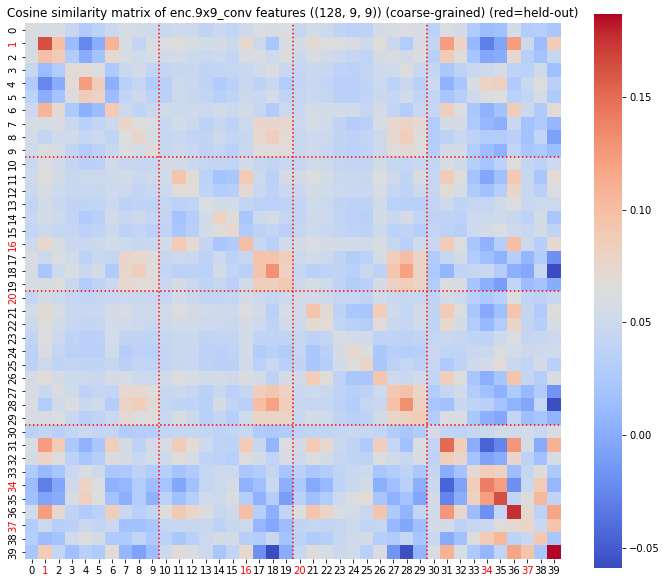

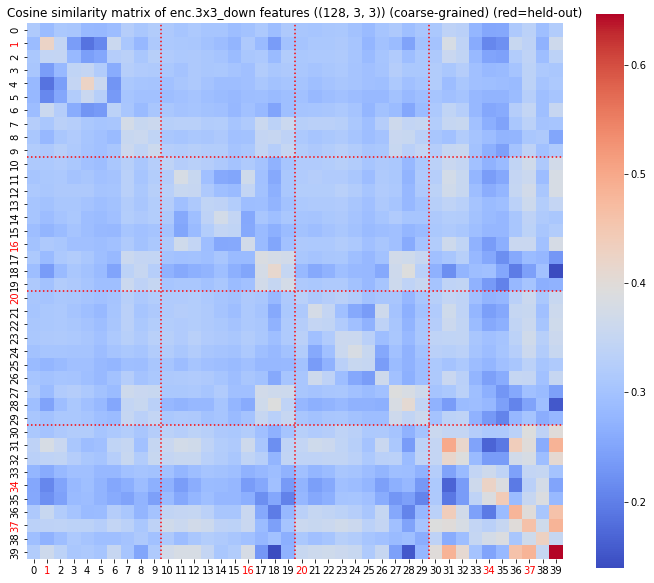

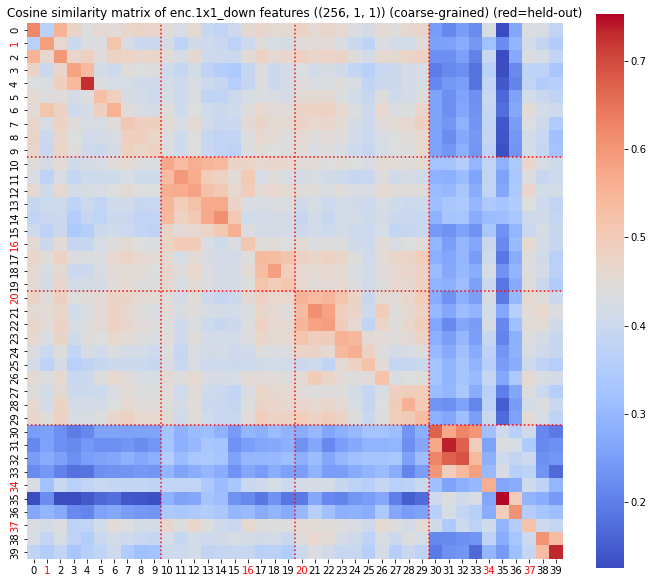

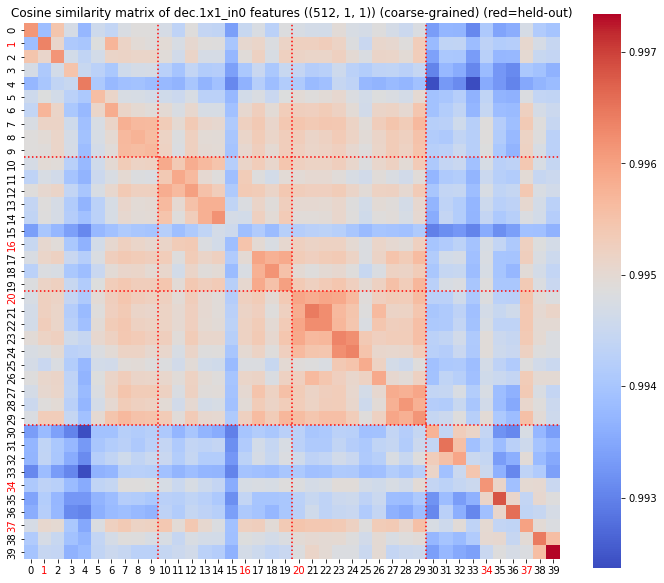

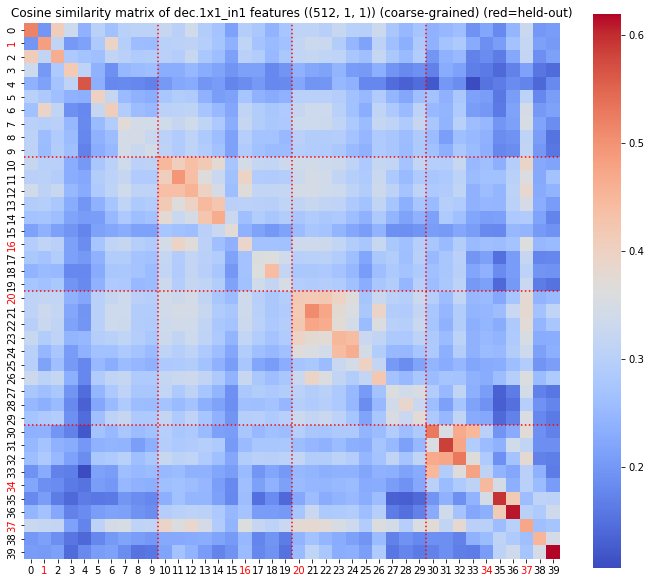

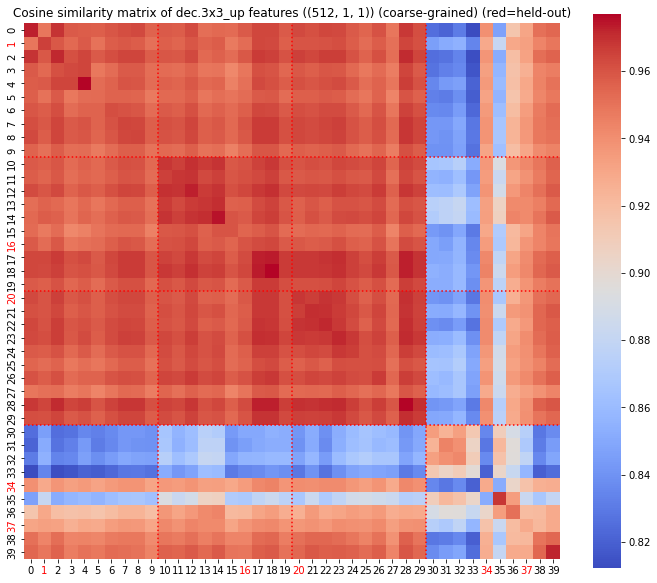

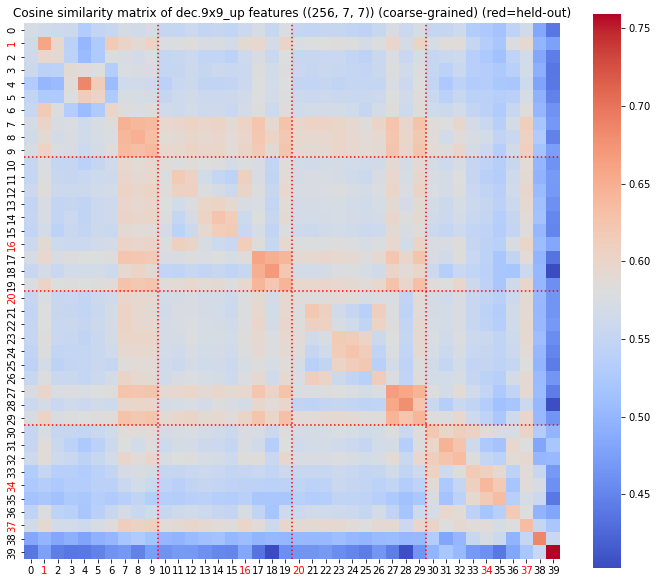

In [102]:
# record_module_list = ["input",
#                'enc.9x9_conv',
#                 'enc.3x3_down',
#                 'enc.1x1_down',
#                 'dec.1x1_in0',
#                 'dec.1x1_in1',
#                 'dec.3x3_up',
#                 'dec.9x9_up',
#                 "dec.9x9_aux_norm",
#                 "dec.9x9_aux_conv", ]
for layername in ['enc.9x9_conv',
                'enc.3x3_down',
                'enc.1x1_down',
                'dec.1x1_in0',
                'dec.1x1_in1',
                'dec.3x3_up',
                'dec.9x9_up',]:
    # layername = "enc.3x3_down"#"dec.1x1_in1"#"dec.3x3_up";#"dec.1x1_in1" # "enc.1x1_down"
    # Compute the cosine similarity matrix
    featmatr = feature_col_test[layername].flatten(start_dim=1)#.squeeze()
    feat_shape = feature_col_test[layername].shape[1:]
    featmat_sparse = featmatr[::10,:]
    cosine_sim_matrix = cosine_similarity(featmat_sparse)
    # print(cosine_sim_matrix)
    n = cosine_sim_matrix.shape[0]
    reshaped = cosine_sim_matrix.reshape(n//100, 100, n//100, 100)
    coarse_grained_matrix = reshaped.mean(axis=(1, 3))
    
    plt.figure(figsize=(12,10))
    sns.heatmap(coarse_grained_matrix, annot=False, cmap='coolwarm', 
                xticklabels=True, yticklabels=True)
    for sep in [10,20,30]:
        plt.axhline(sep, color="r", linestyle=":")
        plt.axvline(sep, color="r", linestyle=":")
    xticks = plt.gca().get_xticklabels()
    yticks = plt.gca().get_yticklabels()
    for i, xtick in enumerate(xticks):
        if i in [1, 16, 20, 34, 37]:  # Change color of every 10th xtick label
            xtick.set_color('red')
    for i, ytick in enumerate(yticks):
        if i in [1, 16, 20, 34, 37]:  # Change color of every 10th ytick label
            ytick.set_color('red')
    plt.axis("image")
    plt.title(f"Cosine similarity matrix of {layername} features ({tuple(feat_shape)}) (coarse-grained) (red=held-out)")
    saveallforms(fig_expdir, f"cosine_sim_{layername}_t{t_str}",)
    plt.show()

### UMap visualization

In [13]:
import umap
import matplotlib.pyplot as plt
# Assuming features is your feature matrix and labels is your label array
reducer = umap.UMAP()
embedding = reducer.fit_transform(feature_col_test["enc.1x1_down"][:,:,0,0])

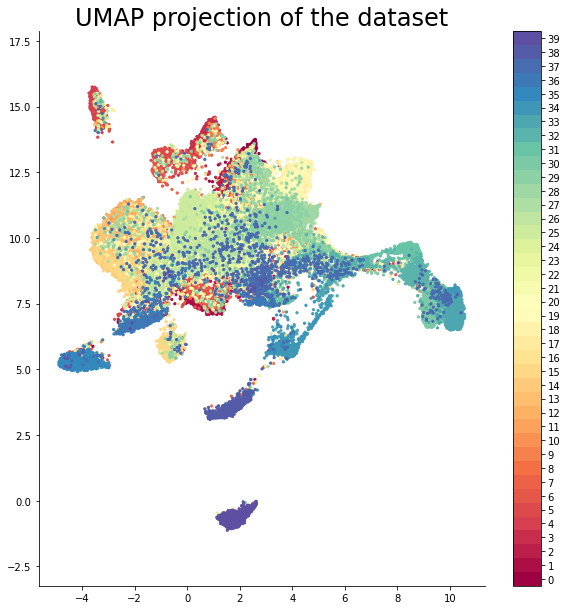

In [16]:
plt.figure(figsize=(10, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_test, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
plt.title('UMAP projection of the dataset', fontsize=24);

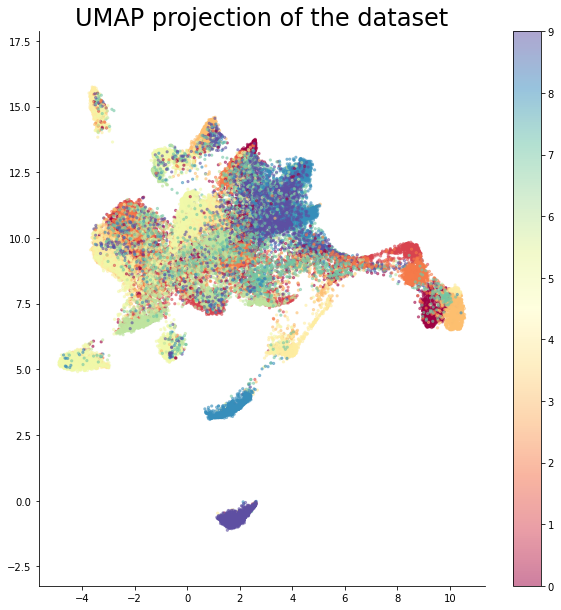

In [19]:
plt.figure(figsize=(10, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=(y_test%10), cmap='Spectral', s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()#boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
plt.title('UMAP projection of the dataset', fontsize=24);

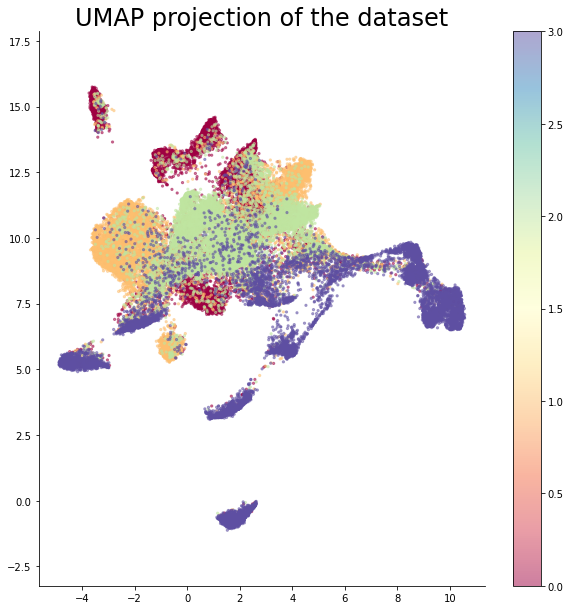

In [20]:
plt.figure(figsize=(10, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=(y_test//10), cmap='Spectral', s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()#boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
plt.title('UMAP projection of the dataset', fontsize=24);

In [ ]:
row_table = {
0: "Constant",
1: "Progression neg 2",
2: "Progression neg 1",
3: "Progression pos 1",
4: "Progression pos 2",
5: "Arithmetic pos",
6: "Arithmetic neg",
7: "XOR",
8: "OR",
9: "AND"
}
from matplotlib.colors import ListedColormap
# Define a discrete colormap
cmap = ListedColormap(['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999', '#d000d0'])


In [21]:
import umap
import matplotlib.pyplot as plt
# Assuming features is your feature matrix and labels is your label array
reducer = umap.UMAP()
embedding2 = reducer.fit_transform(feature_col_test["dec.1x1_in0"][:,:,0,0])

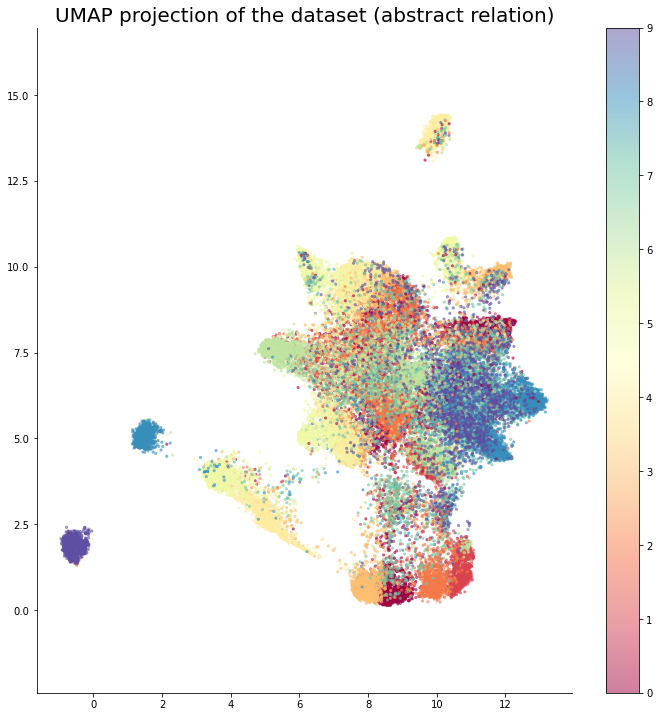

In [34]:
rela_test = (y_test % 10) 
plt.figure(figsize=(12, 12))
plt.scatter(embedding2[:, 0], embedding2[:, 1], c=rela_test, cmap='Spectral', s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar().set_ticks(np.arange(10))#boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
plt.title('UMAP projection of the dataset (abstract relation)', fontsize=20);

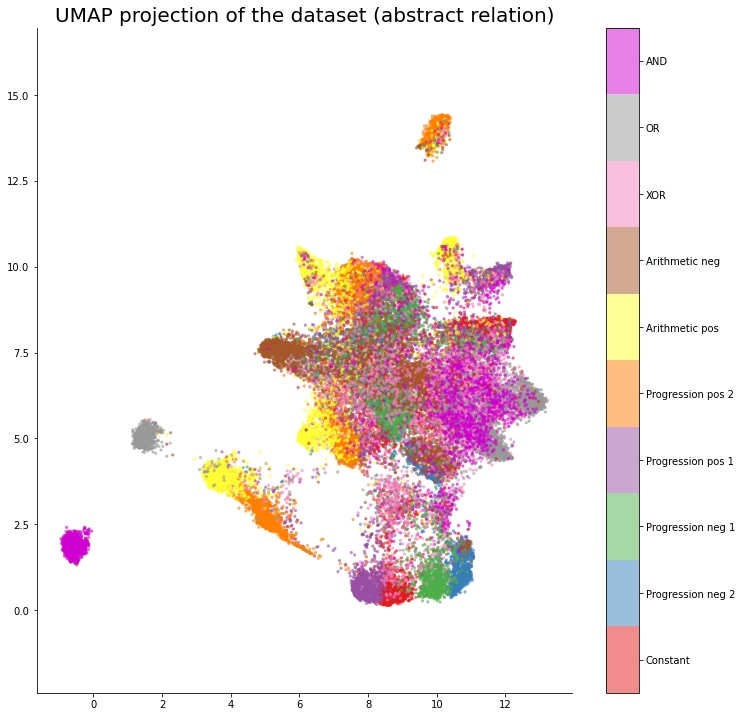

In [47]:
rela_test = (y_test % 10) 
plt.figure(figsize=(12, 12))
plt.scatter(embedding2[:, 0], embedding2[:, 1], c=rela_test, cmap=cmap, s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(11)-0.5)
cb.set_ticks(np.arange(10))#boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
cb.set_ticklabels([row_table[i] for i in range(10)])
plt.title('UMAP projection of the dataset (abstract relation)', fontsize=20);

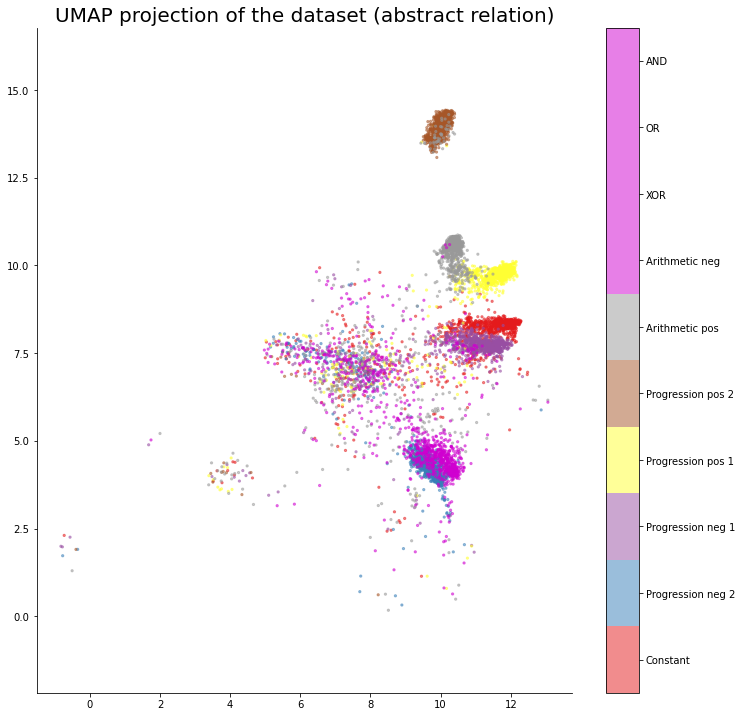

In [55]:
msk = (y_test < 7) & (y_test >= 0)
rela_test = (y_test % 10) 
plt.figure(figsize=(12, 12))
plt.scatter(embedding2[msk, 0], embedding2[msk, 1], c=rela_test[msk], cmap=cmap, s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(11)-0.5)
cb.set_ticks(np.arange(10))#boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
cb.set_ticklabels([row_table[i] for i in range(10)])
plt.title('UMAP projection of the dataset (abstract relation)', fontsize=20);

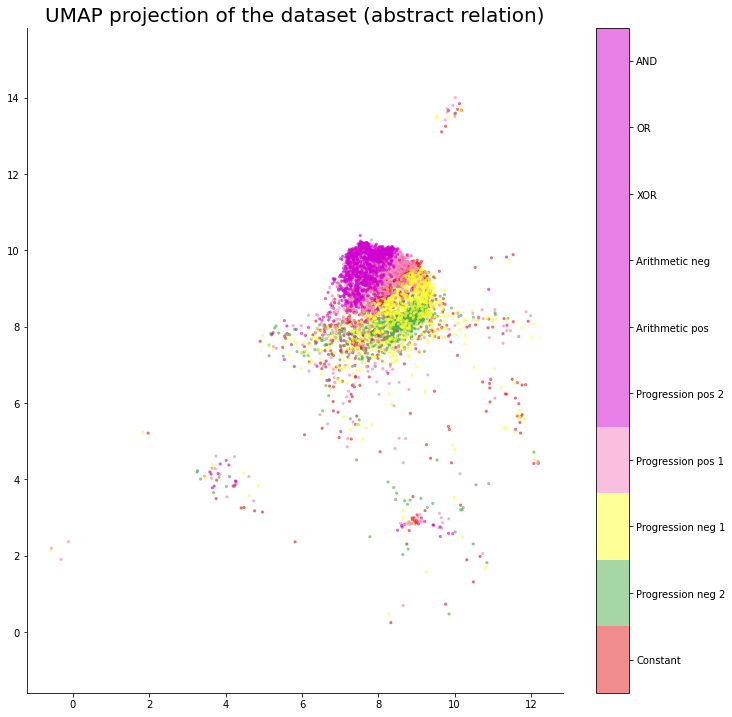

In [58]:
msk = (y_test < 15) & (y_test >= 10)
rela_test = (y_test % 10) 
plt.figure(figsize=(12, 12))
plt.scatter(embedding2[msk, 0], embedding2[msk, 1], c=rela_test[msk], cmap=cmap, s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(11)-0.5)
cb.set_ticks(np.arange(10))#boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
cb.set_ticklabels([row_table[i] for i in range(10)])
plt.title('UMAP projection of the dataset (abstract relation)', fontsize=20);

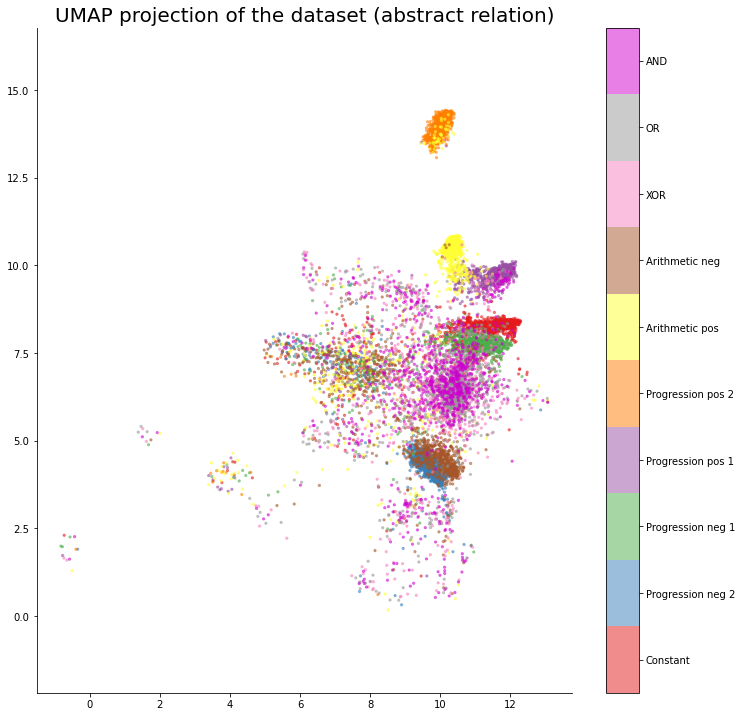

In [56]:
msk = (y_test < 10) & (y_test >= 0)
rela_test = (y_test % 10) 
plt.figure(figsize=(12, 12))
plt.scatter(embedding2[msk, 0], embedding2[msk, 1], c=rela_test[msk], cmap=cmap, s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(11)-0.5)
cb.set_ticks(np.arange(10))#boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
cb.set_ticklabels([row_table[i] for i in range(10)])
plt.title('UMAP projection of the dataset (abstract relation)', fontsize=20);

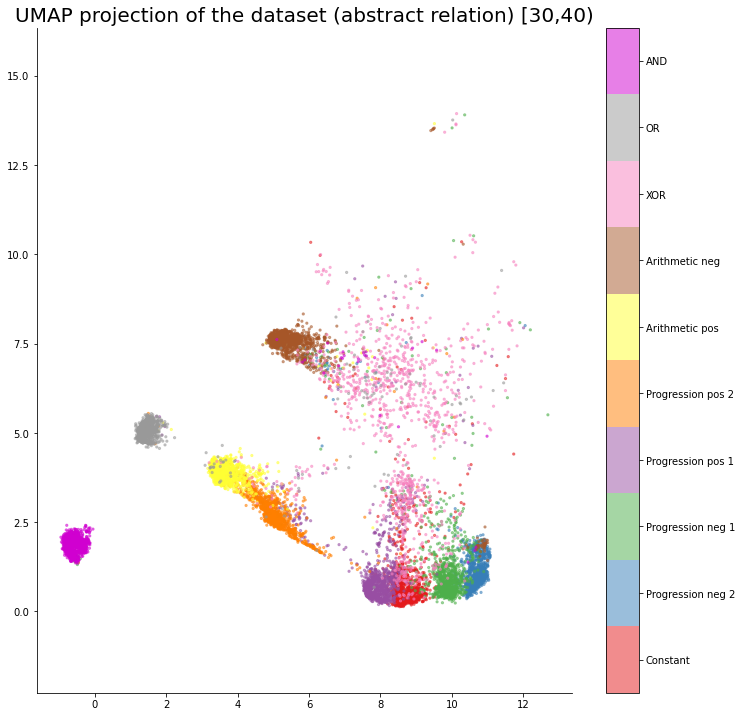

In [61]:
msk = (y_test < 40) & (y_test >= 30)
rela_test = (y_test % 10) 
plt.figure(figsize=(12, 12))
plt.scatter(embedding2[msk, 0], embedding2[msk, 1], c=rela_test[msk], cmap=cmap, s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(11)-0.5)
cb.set_ticks(np.arange(10))#boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
cb.set_ticklabels([row_table[i] for i in range(10)])
plt.title('UMAP projection of the dataset (abstract relation) [30,40)', fontsize=20);

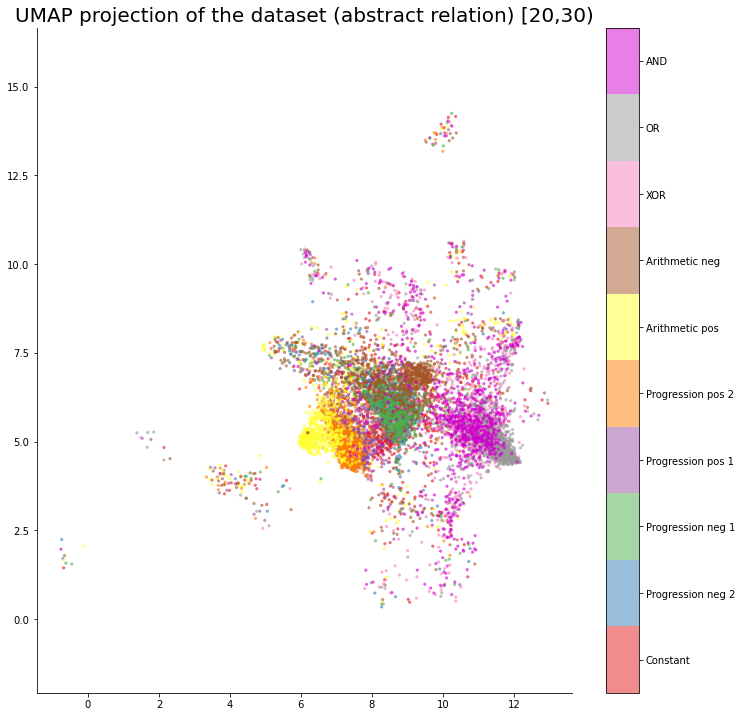

In [62]:
msk = (y_test < 30) & (y_test >= 20)
rela_test = (y_test % 10) 
plt.figure(figsize=(12, 12))
plt.scatter(embedding2[msk, 0], embedding2[msk, 1], c=rela_test[msk], cmap=cmap, s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(11)-0.5)
cb.set_ticks(np.arange(10))#boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
cb.set_ticklabels([row_table[i] for i in range(10)])
plt.title('UMAP projection of the dataset (abstract relation) [20,30)', fontsize=20);

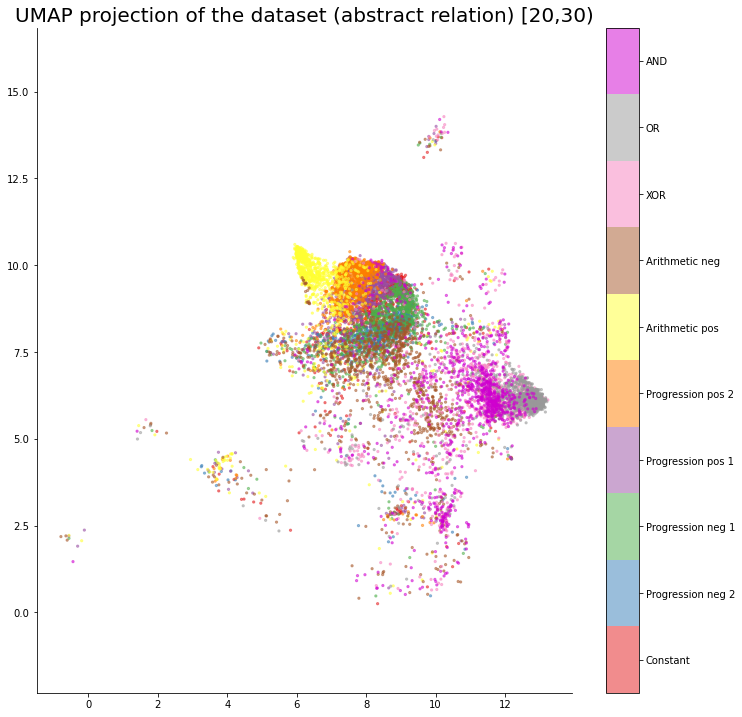

In [63]:
msk = (y_test < 20) & (y_test >= 10)
rela_test = (y_test % 10) 
plt.figure(figsize=(12, 12))
plt.scatter(embedding2[msk, 0], embedding2[msk, 1], c=rela_test[msk], cmap=cmap, s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(11)-0.5)
cb.set_ticks(np.arange(10))#boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
cb.set_ticklabels([row_table[i] for i in range(10)])
plt.title('UMAP projection of the dataset (abstract relation) [20,30)', fontsize=20);

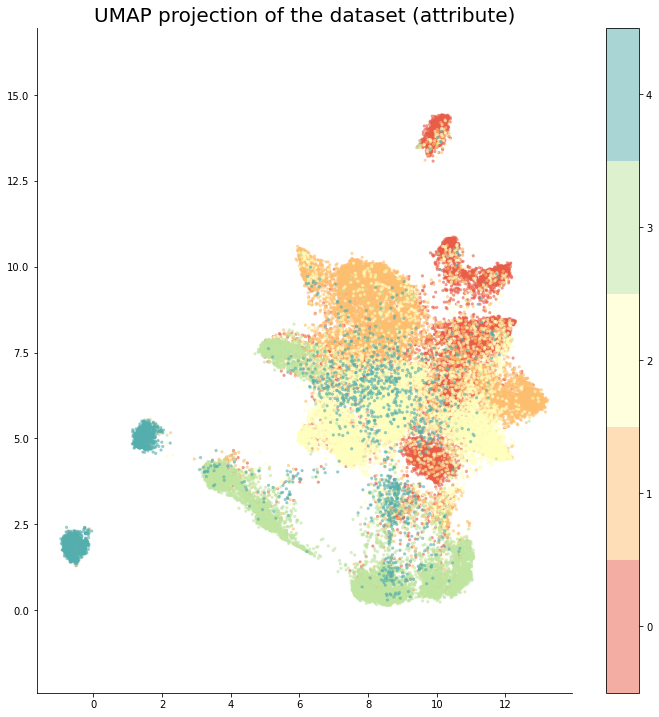

In [49]:
attr_test = (y_test//10) + (y_test > 36).int()
cmap = ListedColormap(sns.color_palette("Spectral", 5))
plt.figure(figsize=(12, 12))
plt.scatter(embedding2[:, 0], embedding2[:, 1], c=attr_test, cmap=cmap, s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))#boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
plt.title('UMAP projection of the dataset (attribute)', fontsize=20);

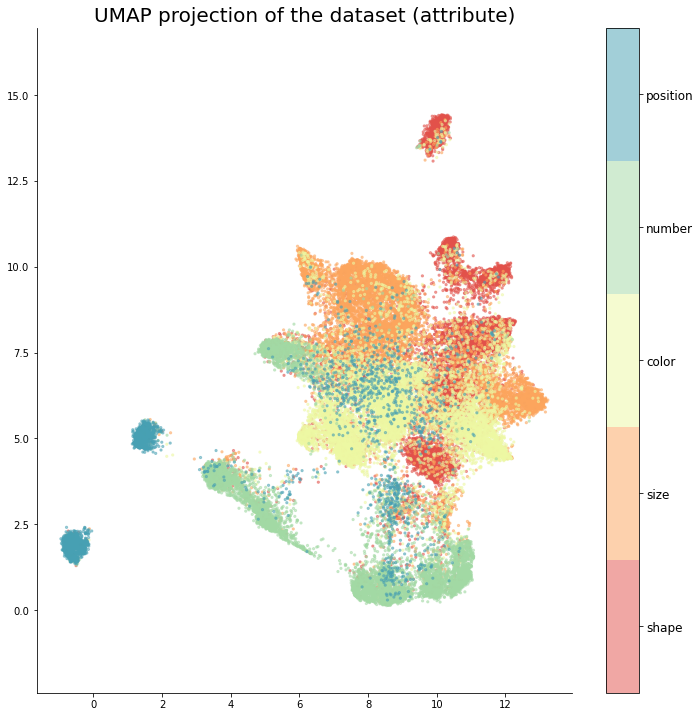

In [51]:
attr_test = (y_test//10) + (y_test > 36).int()
cmap = ListedColormap(sns.color_palette("Spectral", 6))
plt.figure(figsize=(12, 12))
plt.scatter(embedding2[:, 0], embedding2[:, 1], c=attr_test, cmap=cmap, s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(6)-0.5)
cb.set_ticks(np.arange(5),)#["shape","size","color","number","position"])
cb.set_ticklabels(["shape","size","color","number","position"], fontsize=12) #boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
plt.title('UMAP projection of the dataset (attribute)', fontsize=20);